In [1]:
import re
import demoji
import emoji
import warnings
# from google.colab import drive
# drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import date
from collections import OrderedDict
from sklearn.base import BaseEstimator, TransformerMixin

from bs4 import BeautifulSoup

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
df_tweets = pd.read_csv("others_dataset.csv")

In [3]:
df_tweets

,id,name,username,created_at,verified,location,description,followers_count,following_count,tweet_count,account_type,url
0,787405734442958848,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,"Blame @MoistHorse, Inspired by @MakingInvisibl...",1997,5,17090,bot,https://t.co/FpAstfF67l
1,787405734442958848,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,"Blame @MoistHorse, Inspired by @MakingInvisibl...",1997,5,17090,bot,https://t.co/pw6xYLUph5
2,787405734442958848,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,"Blame @MoistHorse, Inspired by @MakingInvisibl...",1997,5,17090,bot,https://t.co/XYsPhTkcDX
3,787405734442958848,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,"Blame @MoistHorse, Inspired by @MakingInvisibl...",1997,5,17090,bot,https://t.co/yyadIxV48k
4,787405734442958848,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,"Blame @MoistHorse, Inspired by @MakingInvisibl...",1997,5,17090,bot,https://t.co/WJxZL1TkfM
...,...,...,...,...,...,...,...,...,...,...,...,...
88127,524121160,차학연 VIXX_N,CHA_NNNNN,2012-03-14T07:48:21.000Z,True,별빛이 있는 곳,NaN,803247,7,3159,human,https://t.co/kfFSga83RW
88128,524121160,차학연 VIXX_N,CHA_NNNNN,2012-03-14T07:48:21.000Z,True,별빛이 있는 곳,NaN,803247,7,3159,human,https://t.co/VS3mHXkZYU
88129,524121160,차학연 VIXX_N,CHA_NNNNN,2012-03-14T07:48:21.000Z,True,별빛이 있는 곳,NaN,803247,7,3159,human,https://t.co/hhfB4q2GkD
88130,524121160,차학연 VIXX_N,CHA_NNNNN,2012-03-14T07:48:21.000Z,True,별빛이 있는 곳,NaN,803247,7,3159,human,https://t.co/h5kv3eJ5Il


In [4]:
def url_text(df):
    pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)' 
    df['url'] = df["uncleaned_text"].str.extract(pattern, expand=True)
    return df

def username(df):
    special_char = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    df["un_no_of_char"] = df["username"].apply(lambda x: len(str(x)))
    df["un_special_char"] = df["username"].apply(lambda x: special_char.search(str(x)) != None)
    df["un_uppercase"] = df["username"].apply(lambda x: bool(re.match(r'\w*[A-Z]\w*', str(x))))
    return df

def name(df):
    special_char = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    df["name_no_of_char"] = df["name"].apply(lambda x: len(str(x)))
    df["name_special_char"] = df["name"].apply(lambda x: special_char.search(str(x)) != None)
    df["name_uppercase"] = df["name"].apply(lambda x: bool(re.match(r'\w*[A-Z]\w*', str(x))))
    return df

def description(df):
    #user_tags = re.compile('[@]')
    #hastags = re.compile('[#]')
    user_tags = r'\B@\w*[a-zA-Z]*\w*'
    hashtags = r'\B#\w*[a-zA-Z]+\w*'
    links = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
    df["des_no_of_usertags"] = df["description"].apply(lambda x: len(re.findall(user_tags, str(x)))) #str(x).count('@'))
    df["des_no_of_hashtags"] = df["description"].apply(lambda x: len(re.findall(hashtags, str(x)))) #str(x).count('#'))
    df["des_external_links"] = df["description"].apply(lambda x: re.findall(links, str(x)) != [])
    df["has_description"] = ~df_tweets["description"].isna() 
    return df

def location(df):
    df["location"] = ~df_tweets["location"].isna() # false = location is NaN; true = has location
    return df
  
def time(df):
    # df["created_time"] = df["created_at"].apply(lambda x : datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z').date())
    # d1 = date(2022, 10, 8) # date we extracted these data 
    df["account_age_in_days"] = df["created_at"].apply(lambda x : (date(2022, 10, 8) - datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z').date()).days)
    df["average_tweets_per_day"] = df["tweet_count"]/df["account_age_in_days"]
    return df

def get_year(date):
    return datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%f%z').year

def get_month(date):
    return datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%f%z').strftime('%b')

def get_weekday(date):
    return datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%f%z').strftime('%a')

class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        year = X.apply(get_year).rename('year')
        month = pd.get_dummies(X.apply(get_month))
        day = pd.get_dummies(X.apply(get_weekday))
        return pd.concat([year, month, day], axis=1) 

def account_type(df):
    df["isFraud"] = df["account_type"].apply(lambda x : 1 if x == 'bot' else 0)
    return df

def convert_TF(variable):
    var = 1 if variable == True else 0
    return var

In [5]:
#df_tweets = time(df_tweets)
df_tweets = account_type(df_tweets)
df_tweets = username(df_tweets)
df_tweets = name(df_tweets)
df_tweets = description(df_tweets)
df_tweets = location(df_tweets)
date = DateTransformer().fit_transform(df_tweets['created_at'])
date.head(10)

boolean_var = ["verified", "location", "un_special_char", "un_uppercase", 
               "name_special_char", "name_uppercase", "des_external_links", 
               "has_description"]

for var in boolean_var:
    df_tweets[var] = df_tweets[var].apply(convert_TF)

In [6]:
df_tweets = df_tweets.drop_duplicates(subset=['id'], keep='first')
new_df_tweets = df_tweets.drop(columns=["id", "created_at", "name", "username", "description", "url"]).join(date)

In [7]:
new_df_tweets

,verified,location,followers_count,following_count,tweet_count,account_type,isFraud,un_no_of_char,un_special_char,un_uppercase,name_no_of_char,name_special_char,name_uppercase,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,0,0,1997,5,17090,bot,1,15,1,0,19,0,1,2,0,0,1,2016,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
5,0,1,785,829,251,human,0,12,0,1,8,0,1,0,0,0,1,2016,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
9,0,0,243,1232,1469,human,0,8,0,1,11,0,0,0,0,0,1,2017,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
13,1,1,737048,128,4739,human,0,13,0,1,14,0,1,1,0,0,1,2012,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
16,1,1,281703,1599,14785,human,0,14,0,0,16,0,1,1,0,1,1,2009,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88114,1,0,2025977,947,194749,human,0,11,1,0,13,0,1,1,0,0,1,2009,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
88116,1,1,367523,17291,24084,human,0,14,0,1,10,0,1,2,0,0,1,2009,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
88120,0,0,395,492,21437,bot,1,14,0,1,16,0,1,0,0,0,1,2012,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
88125,0,0,159,618,3021,human,0,8,0,1,14,0,1,0,0,0,0,2015,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [8]:
saved_df_tweets = new_df_tweets.drop(columns=["account_type"])

In [29]:
saved_df_tweets.to_csv("cleaned_others_dataset.csv", index = False)

In [10]:
# Functions to plot data distributions
def plot_multiple_histograms(data: pd.DataFrame,
                             grouped_col: str,
                             target_col: str,
                             data_labels: dict):
    # Plot
    plt.figure(figsize=(12, 10))
    title = "\n"
    labels: list = list(data_labels.keys())
    for j, i in enumerate(labels):
        x = data.loc[data[grouped_col] == i, target_col]
        mu_x = round(float(np.mean(x)), 3)
        sigma_x = round(float(np.std(x)), 3)
        ax = sns.distplot(x, color=data_labels.get(i), label=i, hist_kws=dict(alpha=.1),
                          kde_kws={'linewidth': 2})
        ax.axvline(mu_x, color=data_labels.get(i), linestyle='--')
        ax.set(xlabel=f"{target_col.title()}", ylabel='Density')
        title += f"Parameters {str(i)}: $G(\mu=$ {mu_x}, $\sigma=$ {sigma_x} \n"
        ax.set_title(target_col.title() + title)
    plt.legend(title="Account Type")
    plt.grid()
    plt.tight_layout()
    plt.show()


def plot_multiple_boxplots(data: pd.DataFrame, grouped_col: str, target_col: str,
                           palette: str = "husl"):
    plt.figure(figsize=(12, 10))

    means: dict = data.groupby([grouped_col])[target_col].mean().to_dict(OrderedDict)
    counter: int = 0

    bp = sns.boxplot(x=grouped_col, y=target_col, data=data, palette=palette, order=list(means.keys()))
    bp.set(xlabel='', ylabel=f"{target_col.title()}")
    ax = bp.axes

    for k, v in means.items():
        # every 4th line at the interval of 6 is median line
        # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
        mean = round(v, 2)
        ax.text(
            counter,
            mean,
            f'{mean}',
            ha='center',
            va='center',
            fontweight='bold',
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))
        counter += 1
    bp.figure.tight_layout()
    plt.grid()
    plt.show()



def add_labels(plot1):
    i = 0
    false_counts = []
    for p in plot1.patches:
        # plot1.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*0.5))
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        plt.text(x+width/2,
              y+height*0.5,
              str(format(int(p.get_height()), ',d')),
              ha='center')
        false_counts.append(p.get_height())
        if (i == 1):
            break
        i+=1
    
    i = 0
    for p in plot1.patches:
        if (i > 1):
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy()
            # percentage = round(100*p.get_height()/(p.get_height()+false_counts[i-2]), 2)
            plt.text(x+width/2,
              false_counts[i-2]+(p.get_height()*0.5),
              str(format(int(p.get_height()), ',d')),
              ha='center')
            # plot1.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), false_counts[i-2]+(p.get_height()*0.5)))
        i+=1

In [11]:
palette: str = "husl"
grouped: str = "account_type"
default_value: str = "unknown"

def get_labels_colors_from_pandas_column(df: pd.DataFrame, column: str, palette: str):
    data_labels: dict = dict()
    #try:
    labels: list = df[column].unique().tolist()
    colors: list = sns.color_palette(palette, len(labels))
    data_labels: dict = dict(zip(labels, colors))
    #except Exception as e:
    #    logger.error(e)
    return data_labels

# Retrieve labels and additional parameters to plot figures
data_labels: dict = get_labels_colors_from_pandas_column(
    df=new_df_tweets, column=grouped, palette=palette)

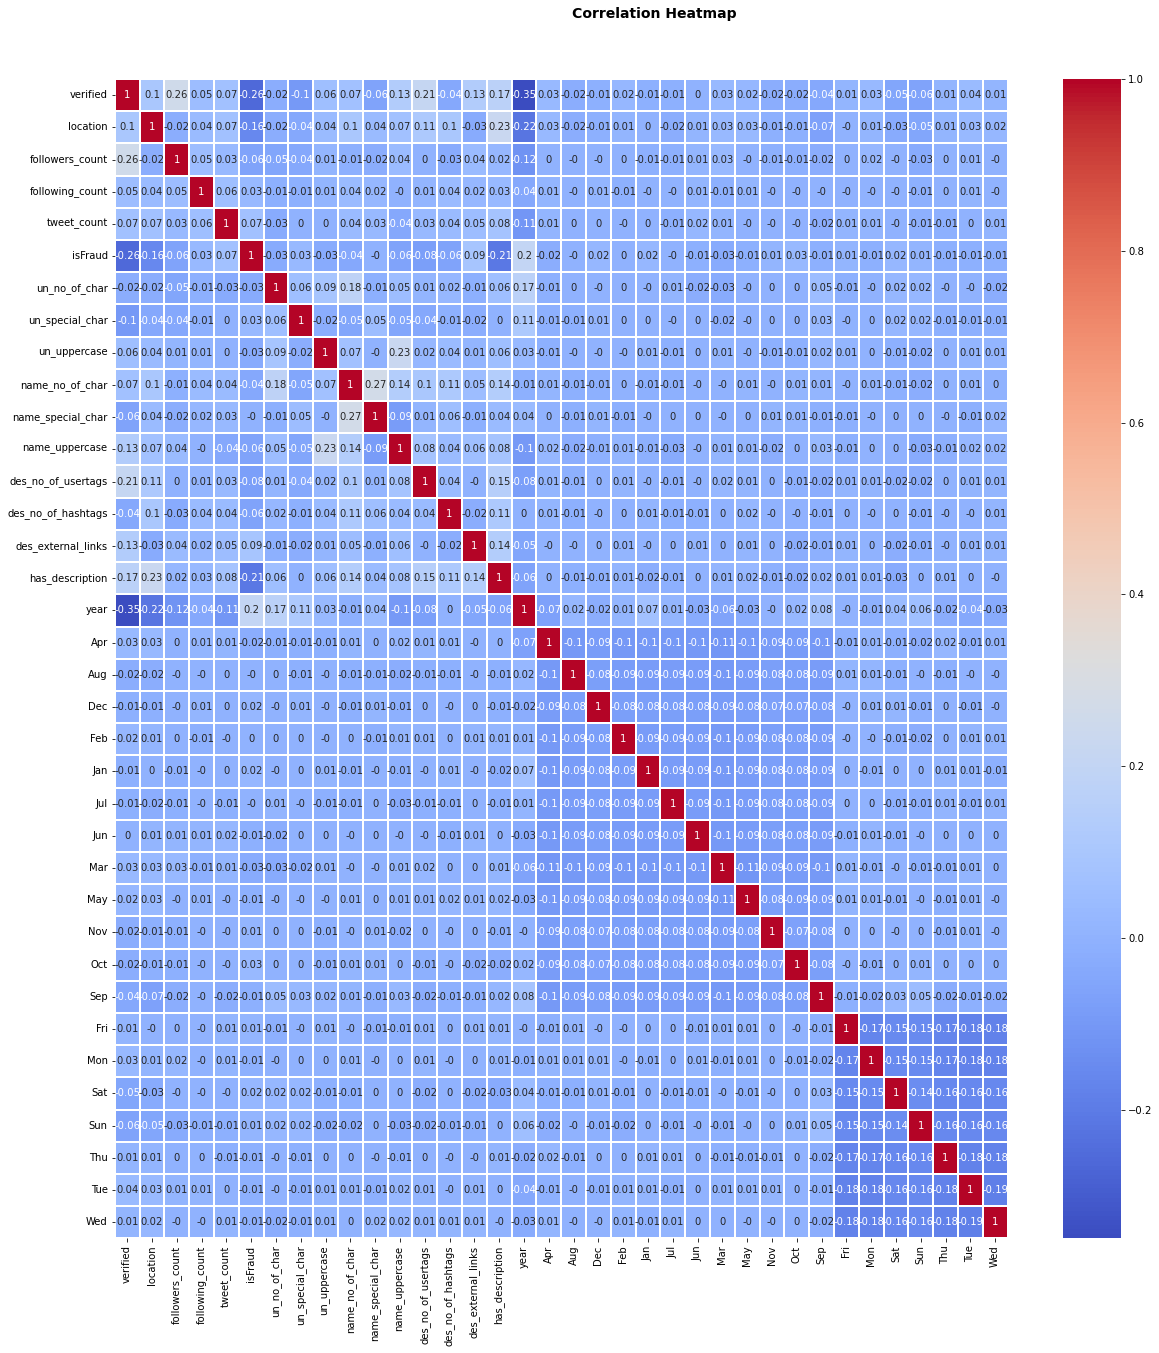

In [12]:
fig, axs = plt.subplots(1,1, figsize=(20,20))
hm = sns.heatmap(round(new_df_tweets.corr(),2), 
                 ax=axs,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 linewidths=.05)
fig.subplots_adjust(top=0.93)
t = fig.suptitle('Correlation Heatmap', fontsize=14, fontweight='bold')

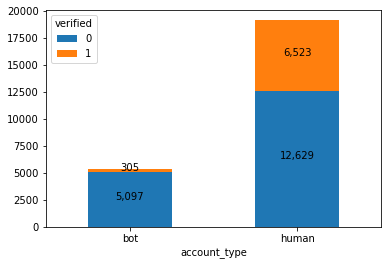

In [13]:
target_col: str = "verified"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot1 = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
add_labels(plot1)

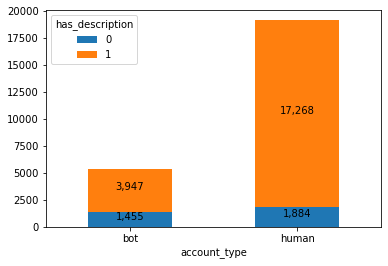

In [14]:
target_col: str = "has_description"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot2 = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0) 
add_labels(plot2)

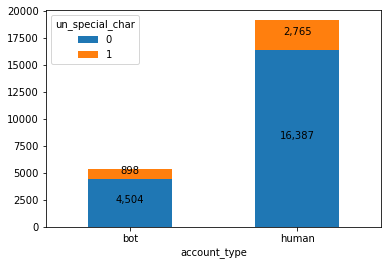

In [15]:
target_col: str = "un_special_char"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
add_labels(plot)

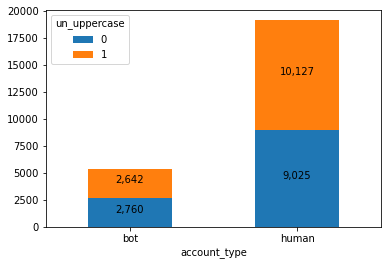

In [16]:
target_col: str = "un_uppercase"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)  
add_labels(plot)

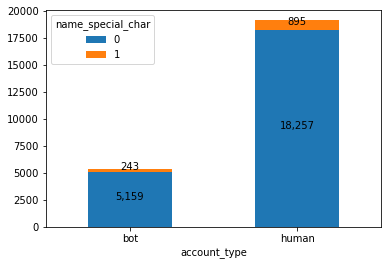

In [17]:
target_col: str = "name_special_char"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0) 
add_labels(plot)

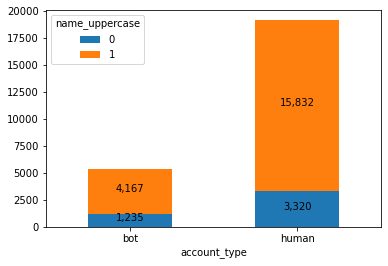

In [18]:
target_col: str = "name_uppercase"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0) 
add_labels(plot)

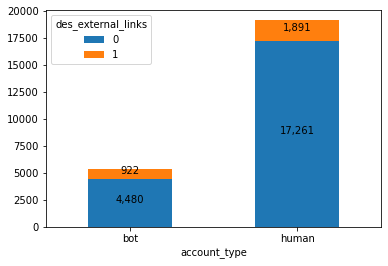

In [19]:
target_col: str = "des_external_links"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0) 
add_labels(plot)

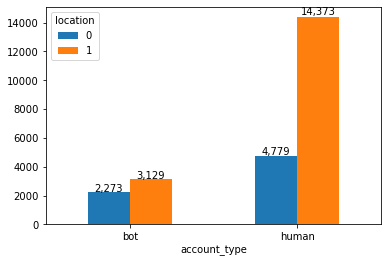

In [20]:
target_col: str = "location"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot3 = twitter_accounts_df2.plot(kind='bar', stacked=False)
plt.xticks(rotation=0) 
# add_labels(plot3)
for p in plot3.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
            y+height*1.01,
            str(format(int(p.get_height()), ',d')),
            ha='center')

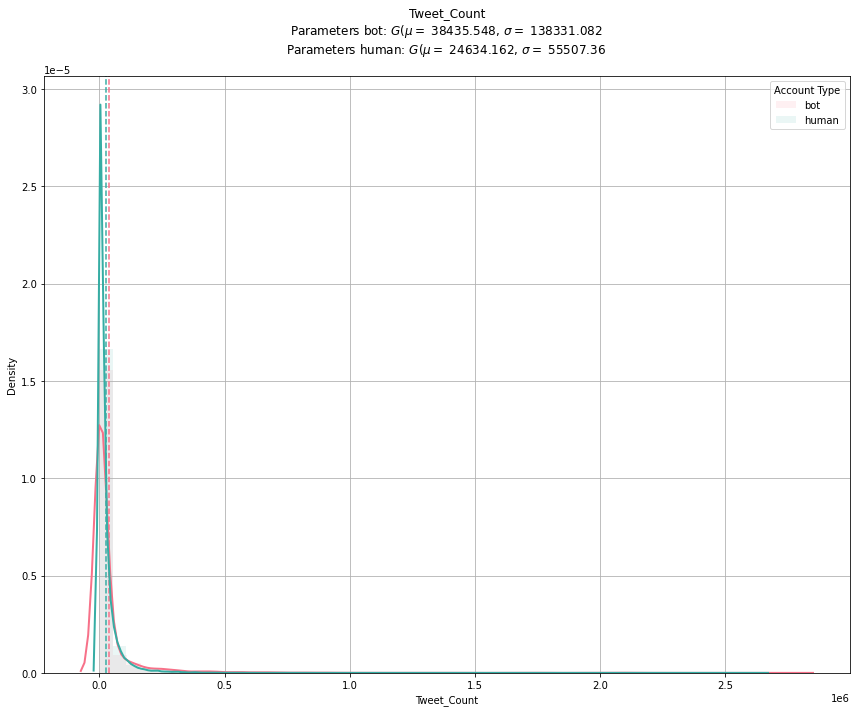

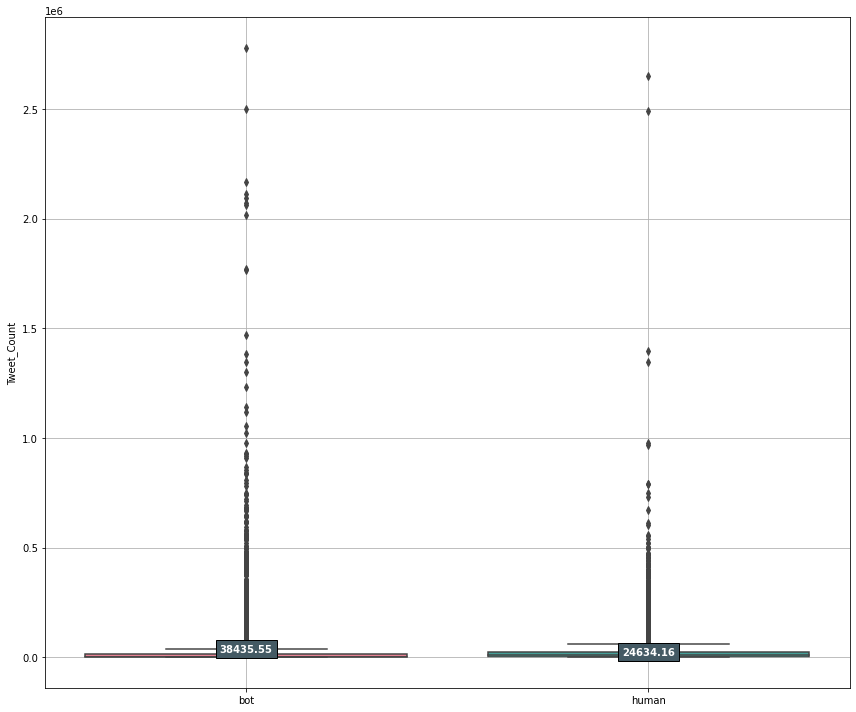

In [21]:
target: str = "tweet_count"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

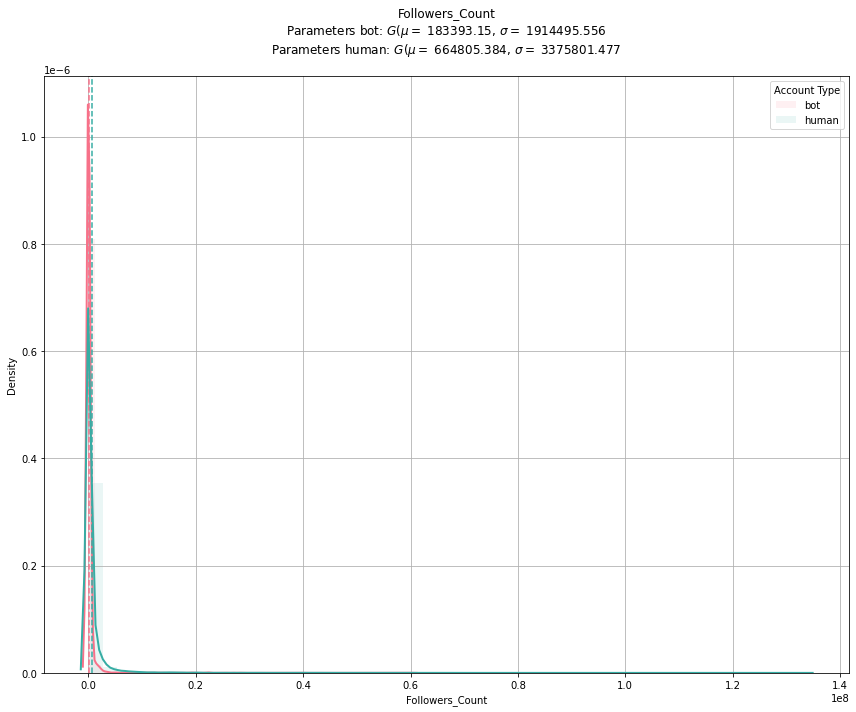

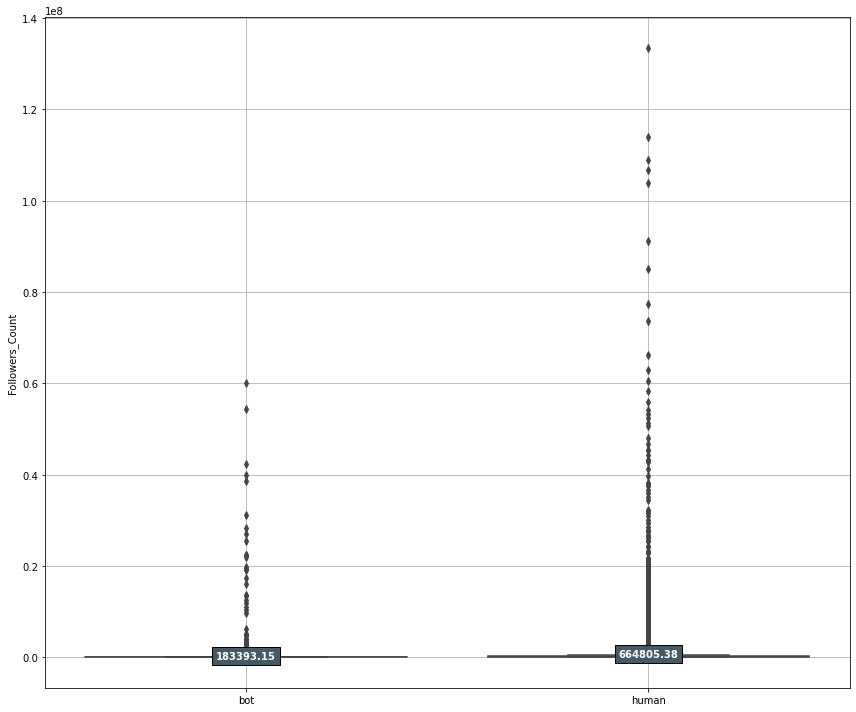

In [22]:
target: str = "followers_count"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

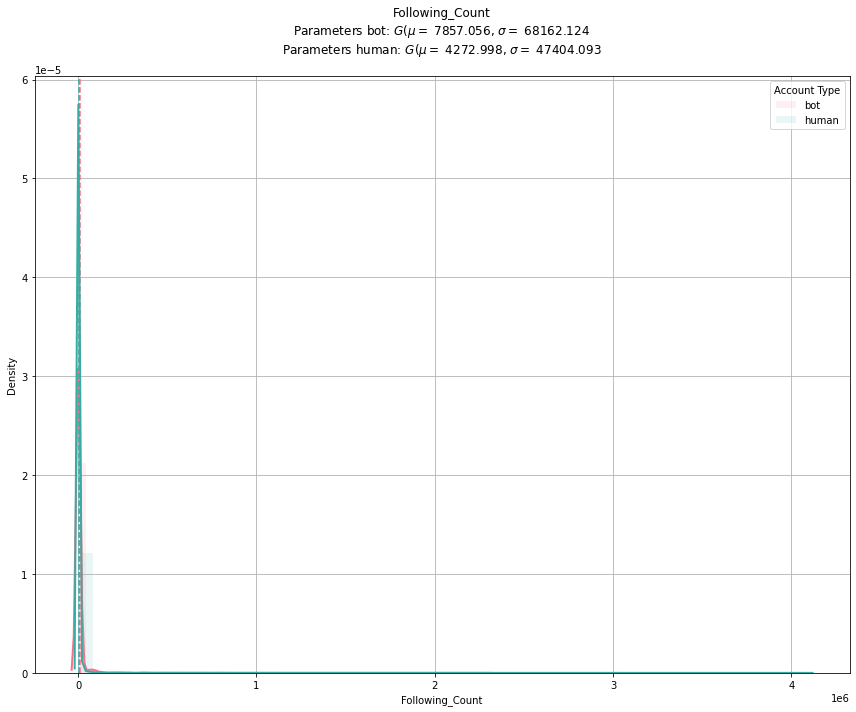

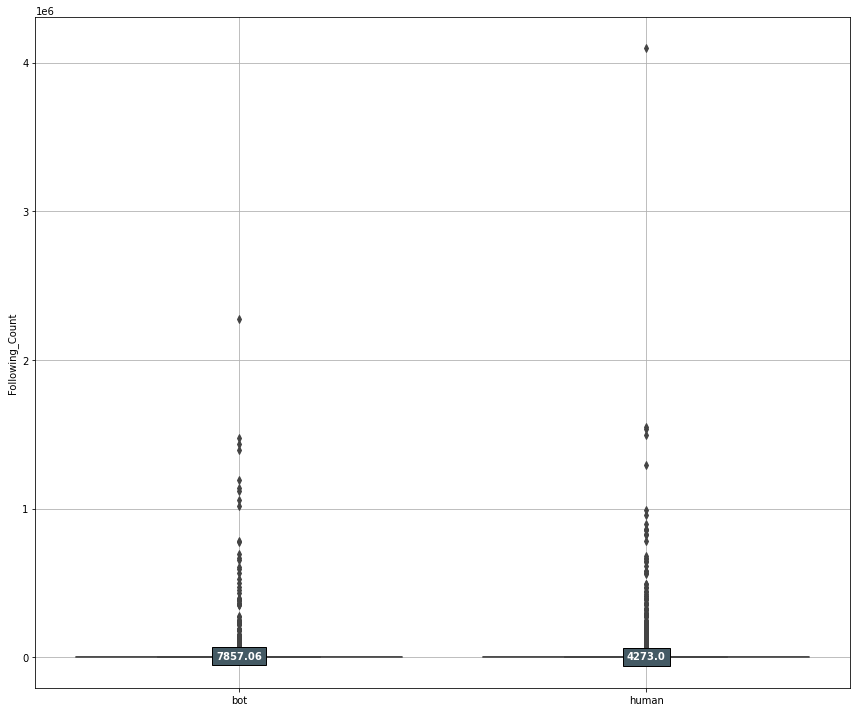

In [23]:
target: str = "following_count"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

In [24]:
"""
target: str = "average_tweets_per_day"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)
"""

'\ntarget: str = "average_tweets_per_day"  \n# Extract histograms\nplot_multiple_histograms(data=new_df_tweets, \n                         grouped_col=grouped,\n                         data_labels=data_labels,\n                         target_col=target)\n# Extract Box-plots\nplot_multiple_boxplots(data=new_df_tweets,\n                       grouped_col=grouped,\n                       target_col=target,\n                       palette=palette)\n'

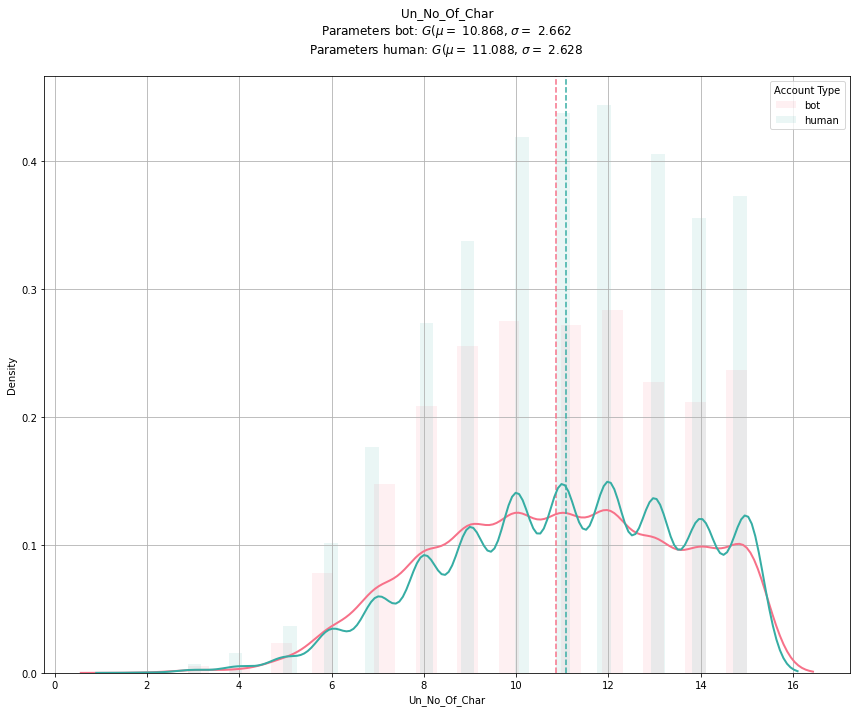

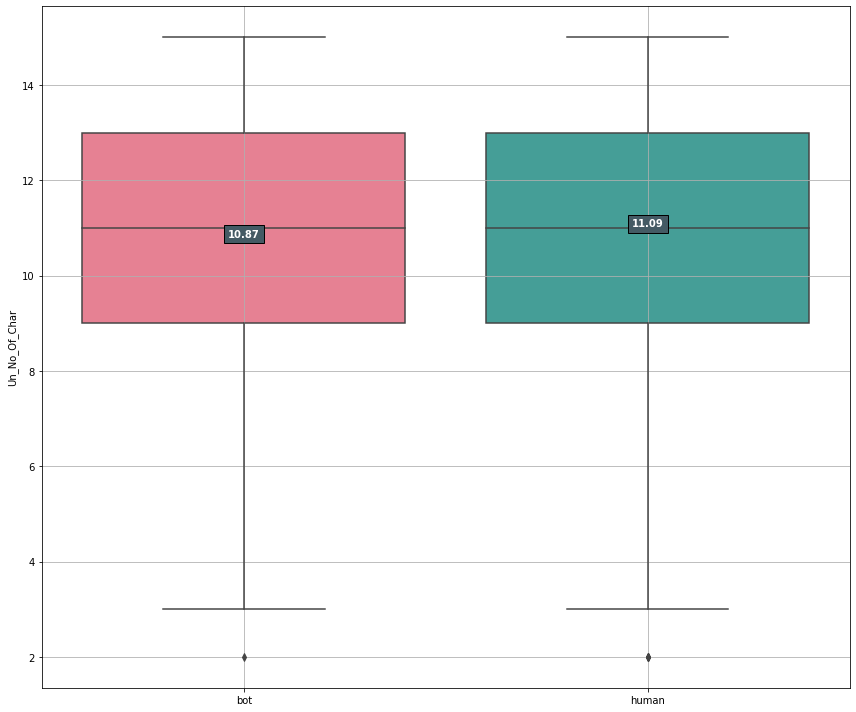

In [25]:
target: str = "un_no_of_char"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

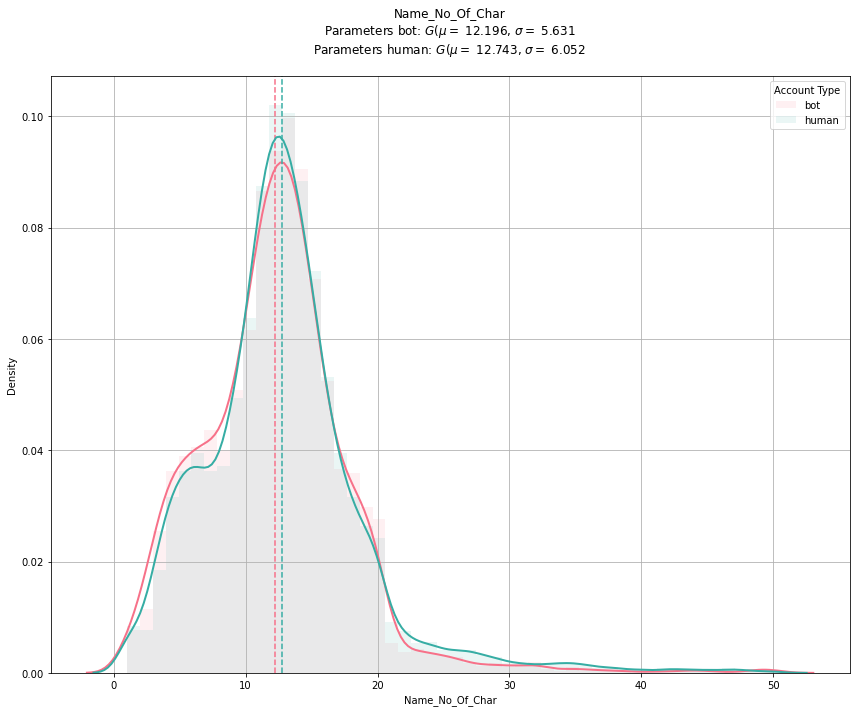

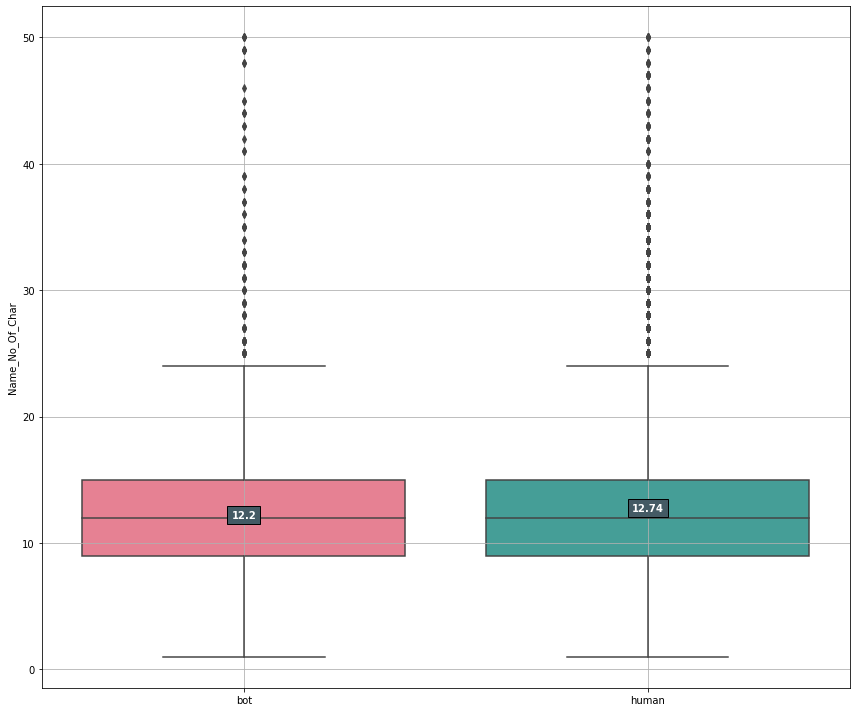

In [26]:
target: str = "name_no_of_char"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

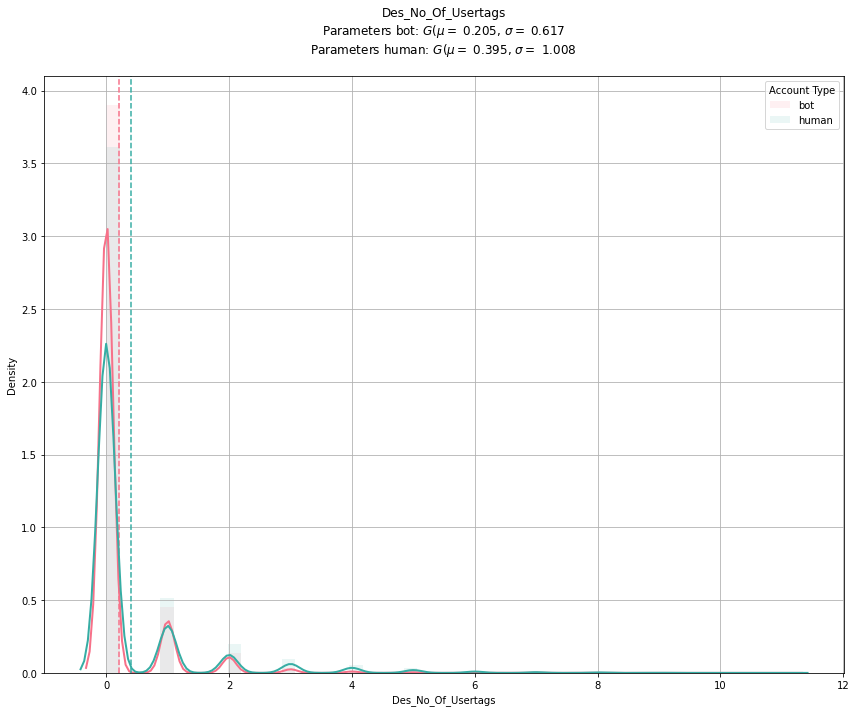

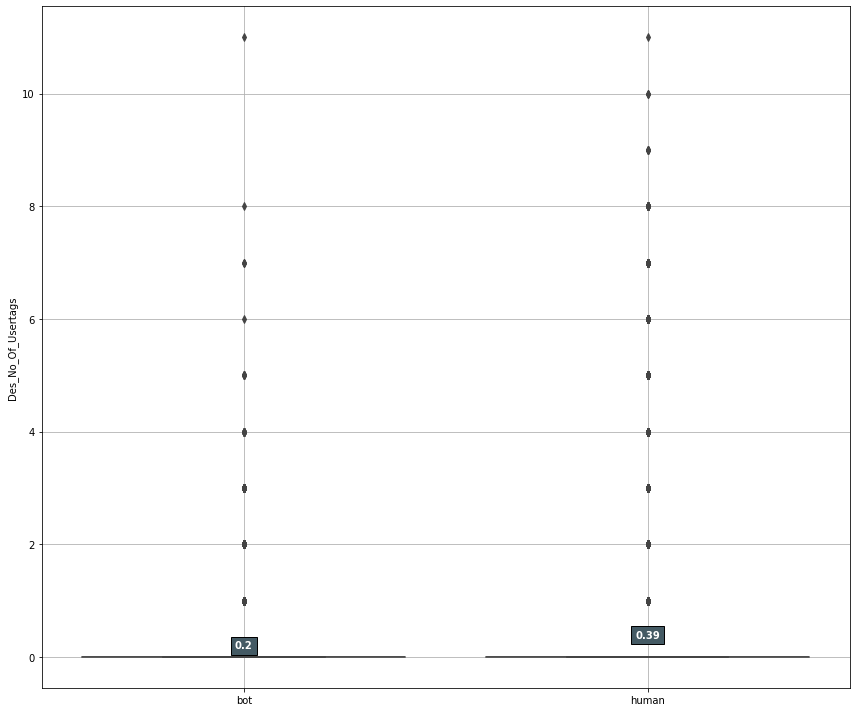

In [27]:
target: str = "des_no_of_usertags"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

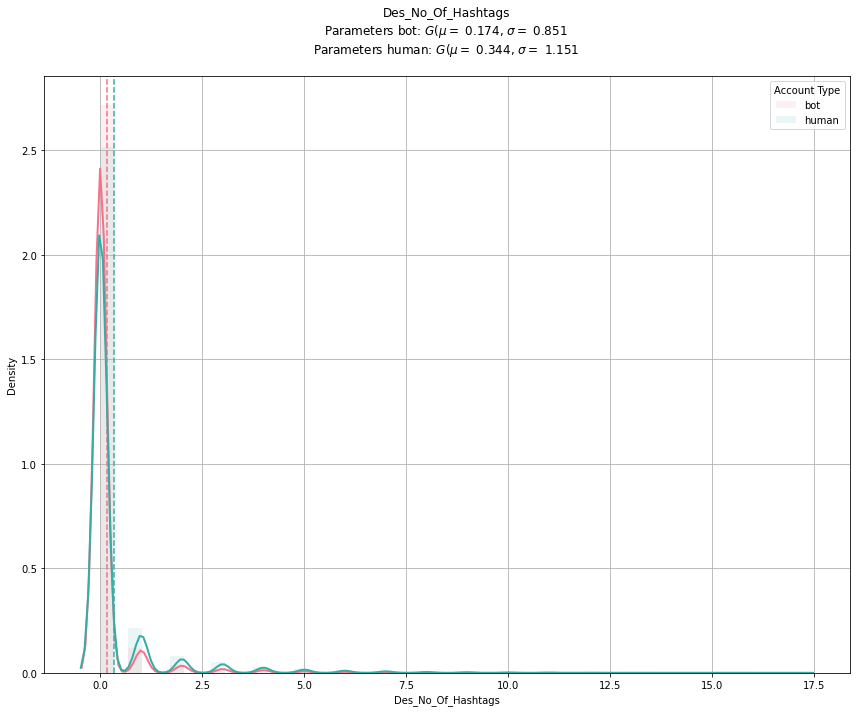

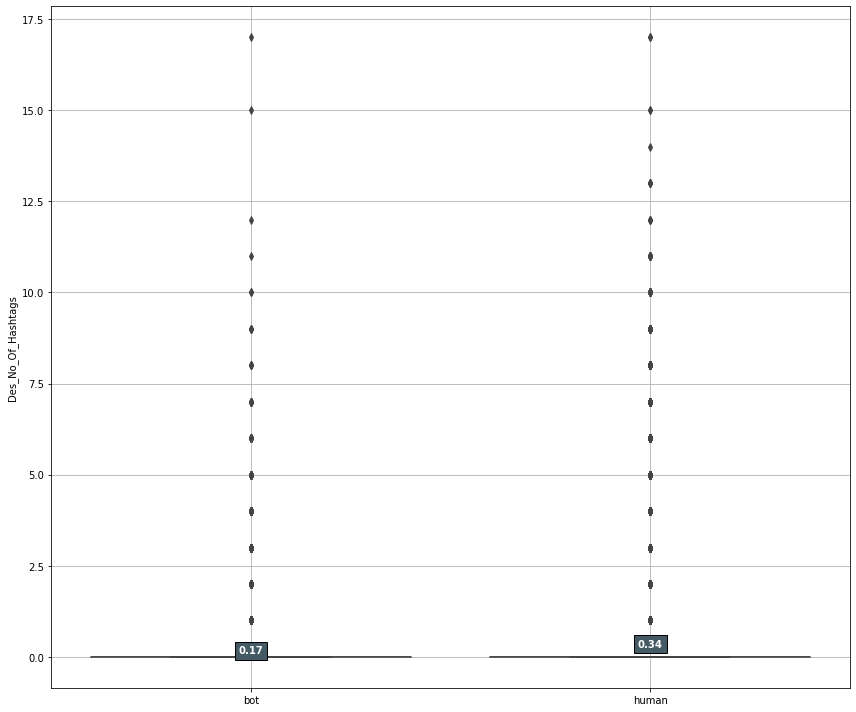

In [28]:
target: str = "des_no_of_hashtags"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)